In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def rayleigh_LWMB(B, f, x, deriv=False):
    """ 
    Compute Rayleigh quotient and its derivative w.r.t. B
    Assuming M = B^T @ B
    
    Input: B, f, x, deriv
    B - NxN matrix of parameters determining the covariance matrix (M=B.T @ B)
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: r, dr
                else: r
    r - value of un-normalized Rayleigh quotient (x.T @ L @ x)
    dr - derivative of un-normalized Rayleight quotient w.r.t. B
    """
    
    # Some additional matrices:
    # F - NxNxC matrix of difference of feature vectors for each pair of training images
    # M - CxC matrix of covariance of each pair of training images; M = B.T @ B
    # W - NxN adjacency matrix of the graph; w_ij = exp((F_ij.T @ M @ F_ij) / (F_ij.T @ F_ij))
    # D - NxN degree matrix of graph; D = diag(W @ 1)
    # L - NxN graph laplacian matrix; L = D - W
    # Q - NxN auxiliary matrix to compute dr
    # X - NxN auxiliary matrix to compute dr
    
    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B

    # create W and Q
    W = np.zeros((num_train, num_train))
    Q = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            if i==j:
                W[i][j] = 0
                Q[i][j] = 0
            else:
                phi_sq = np.sum(F[i][j].T @ F[i][j]) + 0.01
                W[i][j] = np.exp((F[i][j].T @ M @ F[i][j])/phi_sq)
                Q[i][j] = (1/phi_sq) * W[i][j]
    
            
#     # create W - EACH ROUND TAKES ABOUT 10 MIN; MAYBE LESS MEMORY USAGE
#     fmf = np.einsum('ija,ijk,ak->ij',F,F,M)
#     nrmsq_f = np.einsum('ijk,ijk->ij',F,F)
#     W = np.exp(fmf / nrmsq_f)
    
#     # create W - KERNEL DIES
#     temp = np.tensordot(F,M, axes=([2],[1]))
#     fmf = np.sum(F * temp, axis=2)
#     nrmsq_f = np.sum(F * F, axis=2)
#     W = np.exp(fmf/nrmsq_f)
            
    # create L
    D = np.diag(W @ np.ones(num_train))
    L = D - W
    
    # calculate r
    r = x.T @ L @ x
    
    
    if deriv:
        
        # create X
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)
        
        # calculate drdM - TAKES TOO LONG
        QX = np.multiply(Q, X)
        drdM = np.zeros((f_sz, f_sz))
        for s in range(f_sz):
            for t in range(f_sz):
                Fst = np.multiply(F[:,:,s], F[:,:,t])
                drdM[s][t] = -1 * np.sum(np.multiply(QX, Fst))
                
        # calculate dr w.r.t B
        dr = B @ (drdM + drdM.T)
        
        
        return r,dr
    else:
        return r

In [37]:
def rayleigh_LWMB_neg(B, f, x, deriv=False):
    """ 
    Compute Rayleigh quotient and its derivative w.r.t. B
    Assuming M = B^T @ B
    
    Input: B, f, x, deriv
    B - NxN matrix of parameters determining the covariance matrix (M=B.T @ B)
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: r, dr
                else: r
    r - value of un-normalized Rayleigh quotient (x.T @ L @ x)
    dr - derivative of un-normalized Rayleight quotient w.r.t. B
    """
    
    # Some additional matrices:
    # F - NxNxC matrix of difference of feature vectors for each pair of training images
    # M - CxC matrix of covariance of each pair of training images; M = B.T @ B
    # W - NxN adjacency matrix of the graph; w_ij = exp(- F_ij.T @ M @ F_ij)
    # D - NxN degree matrix of graph; D = diag(W @ 1)
    # L - NxN graph laplacian matrix; L = D - W
    # X - NxN auxiliary matrix to compute dr
    
    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B

    # create W
    W = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            if i==j:
                W[i][j] = 0
            else:
                W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))

    
#     # create W - EACH ROUND TAKES ABOUT 10 MIN; MAYBE LESS MEMORY USAGE
#     fmf = np.einsum('ija,ijk,ak->ij',F,F,M)
#     nrmsq_f = np.einsum('ijk,ijk->ij',F,F)
#     W = np.exp(fmf / nrmsq_f)
    
#     # create W - KERNEL DIES
#     temp = np.tensordot(F,M, axes=([2],[1]))
#     fmf = np.sum(F * temp, axis=2)
#     nrmsq_f = np.sum(F * F, axis=2)
#     W = np.exp(fmf/nrmsq_f)
            
    # create L
    D = np.diag(W @ np.ones(num_train))
    L = D - W
    
    # calculate r
    r = x.T @ L @ x
    
    if deriv:
        
        # create X
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)
        
        # calculate drdM - TAKES TOO LONG
        XW = np.multiply(X, W)
        drdM = np.zeros((f_sz, f_sz))
        for s in range(f_sz):
            for t in range(f_sz):
                Fst = np.multiply(F[:,:,s], F[:,:,t])
                drdM[s][t] = np.sum(np.multiply(XW, Fst))
                
        # calculate dr w.r.t B
        dr = B @ (drdM + drdM.T)
        
        
        return r,dr
    else:
        return r

In [46]:
def rayleigh_tr(B, f, x, mu=1, deriv=False):
    """ 
    Compute loss function and its derivative w.r.t. B
    Loss = x.T @ L @ x + mu * tr(M)
    Assuming M = B^T @ B
    
    Input: B, f, x, mu, deriv
    B - NxN matrix of parameters determining the covariance matrix (M=B.T @ B)
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    mu - scalar parameter of the loss function
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: E, dE
                else: E
    E - loss value with current B
    dE - derivative of loss function w.r.t. B at current B
    """
    
    # Some additional matrices:
    # F - NxNxC matrix of difference of feature vectors for each pair of training images
    # M - CxC matrix of covariance of each pair of training images; M = B.T @ B
    # W - NxN adjacency matrix of the graph; w_ij = exp(- F_ij.T @ M @ F_ij)
    # D - NxN degree matrix of graph; D = diag(W @ 1)
    # L - NxN graph laplacian matrix; L = D - W
    # X - NxN auxiliary matrix to compute dr
    
    # create F
    f_sz, num_train = f.shape
    Fj = np.broadcast_to([f.T], (num_train, num_train, f_sz))
    Fi = np.transpose(Fj, (1,0,2))
    F = Fi - Fj
    
    # create M
    M = B.T @ B

    # create W
    W = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            if i==j:
                W[i][j] = 0
            else:
                W[i][j] = np.exp(-1*(F[i][j].T @ M @ F[i][j]))

    
#     # create W - EACH ROUND TAKES ABOUT 10 MIN; MAYBE LESS MEMORY USAGE
#     fmf = np.einsum('ija,ijk,ak->ij',F,F,M)
#     nrmsq_f = np.einsum('ijk,ijk->ij',F,F)
#     W = np.exp(fmf / nrmsq_f)
    
#     # create W - KERNEL DIES
#     temp = np.tensordot(F,M, axes=([2],[1]))
#     fmf = np.sum(F * temp, axis=2)
#     nrmsq_f = np.sum(F * F, axis=2)
#     W = np.exp(fmf/nrmsq_f)
            
    # create L
    D = np.diag(W @ np.ones(num_train))
    L = D - W
    
    # calculate r
    r = x.T @ L @ x
    
    # calculate E
    E = r + mu * np.trace(M)
    
    if deriv:
        
        # create X
        X = np.broadcast_to([x], (len(x), len(x))).T
        X = ((X - X.T)**2)
        
        # calculate drdM - TAKES TOO LONG
        XW = np.multiply(X, W)
        drdM = np.zeros((f_sz, f_sz))
        for s in range(f_sz):
            for t in range(f_sz):
                Fst = np.multiply(F[:,:,s], F[:,:,t])
                drdM[s][t] = np.sum(np.multiply(XW, Fst))
                
        # calculate dr w.r.t. B
        drdB = B @ (drdM + drdM.T)
        
        # calculate dE w.r.t. B
        dE = drdB + 2 * mu * B
        
        return E,dE
    else:
        return E

# Visualize r w.r.t. B

## Random exploration

In [7]:
# load descriptors and image labels
des = np.loadtxt('../../data/des.txt', dtype=np.float32)
train_y = np.loadtxt('../../data/lbls.txt', dtype=np.float32)

# create f and x
f = des.T
x = train_y * 2 -1

In [39]:
def test_random_params(rayleigh_func, R, num_pts, f, x, plott=False, deriv=False):
    """
    Find values of r w.r.t. random values of B
    
    Input: rayleigh_func, R, num_pts, f, x, plott, deriv
    rayleigh_func - function used to generate r from B; can be rayleigh_LWMB or rayleigh_LWMB_neg
    R - range of random B entries; 1e8 for rayleigh_LWMB and 1e-4 for rayleigh_LWMB_neg
    num_pts - number of random points to try
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    plott - whether or not to plot obtained values of r
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: rs, drs
                else: rs
    rs - list of obtained values of r
    drs - list of obtained values of dr
    """
    
    f_sz, num_train = f.shape
    rs = []
    drs = []
    
    for pt in range(num_pts):
        
        # create random B
        B = R*np.random.random_sample((f_sz,f_sz)) # random_sample returns uniform floats in [0, 1)
        
        # find r, dr for current B
        if deriv:
            r, dr = rayleigh_func(B, f, x, deriv=True)
            rs.append(r)
            drs.append(dr)
        else:
            r = rayleigh_func(B, f, x, deriv=False)
            rs.append(r)
            
    if plott:
        plt.figure(figsize=(6,6))
        plt.hist(rs)
        plt.title('rs')
    
    
    if deriv:
        return rs, drs
    else:
        return rs
            

Text(0.5, 1.0, 'rs - rayleigh_LWMB')

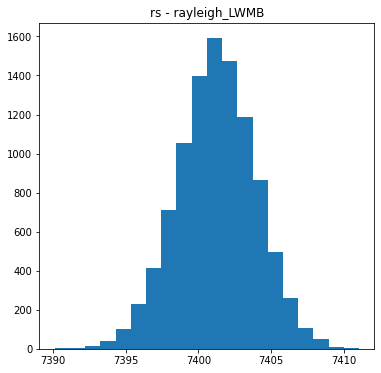

In [42]:
# plot histogram of 10000 randomly generated r's via random B's
rs = np.loadtxt('../../data/rs.txt', dtype=np.float64)
plt.figure(figsize=(6,6))
plt.hist(rs, 20)
plt.title('rs - rayleigh_LWMB')

# if 'rs.txt' does not exist, run below code to generate it - TAKES ~1 HOUR
# rs = test_random_params(rayleigh_LWMB, 100000000, 10000, f, x, plott=True, deriv=False)
# plt.title('rs - rayleigh_LWMB')
# np.savetxt('../../data/rs.txt', np.array(rs))

Text(0.5, 1.0, 'rs - rayleigh_LWMB_neg')

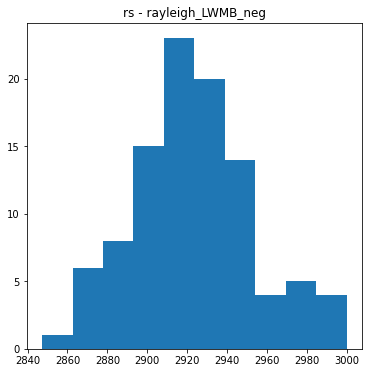

In [44]:
rs = test_random_params(rayleigh_LWMB_neg, 0.0001, 100, f, x, plott=True, deriv=False)
plt.title('rs - rayleigh_LWMB_neg')

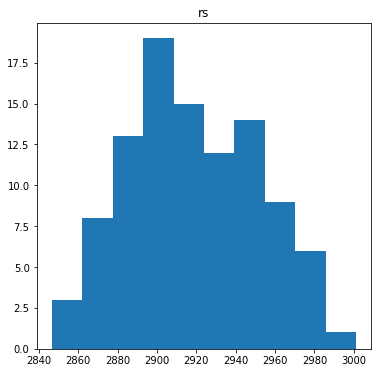

In [47]:
rs = test_random_params(rayleigh_tr, 0.0001, 100, f, x, plott=True, deriv=False)

## Visualize a range

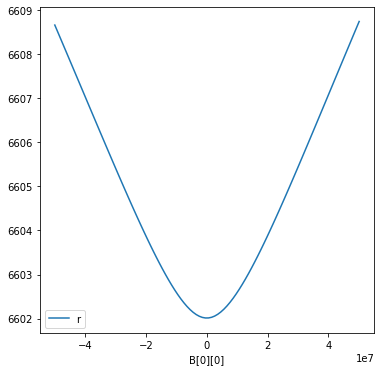

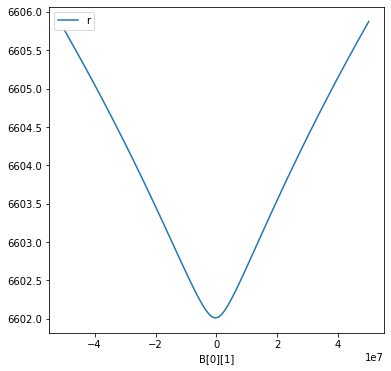

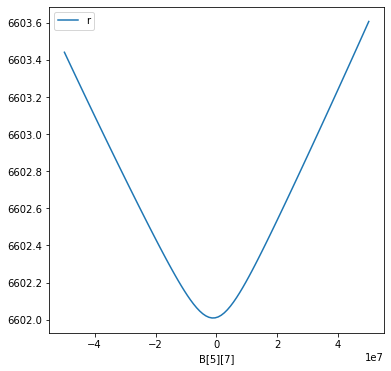

In [82]:
def test_range_ax(l, precision, ax, f, x, B0, plott=False, deriv=False):
    """
    Find values of r in a continuous range of different B's (single entry)
    
    Input: l, presision, B0, f, x, plott, deriv
    l - length of the range
    precision - number of points inside the range divided by l
    ax - tuple defining entry of B that we want to change
    B0 - center point of the range
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    plott - whether or not to plot obtained values of r
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: rs, drs
                else: rs
    rs - list of obtained values of r
    drs - list of obtained values of dr
    """
    
    # create offsets of the range
    offs = np.linspace(-(l-1)/2, (l-1)/2, int(l*precision))
    
    # find i, j of target entry
    i, j = ax
    
    # find r's in the range
    B = B0.copy()
    rs = []
    drs = []
    for offset in offs:
        B[i][j] = B0[i][j] + offset
        
        if deriv:
            r, dr = rayleigh_LWMB(B, f, x, deriv=True)
            rs.append(r)
            drs.append(dr)
        else:
            r = rayleigh_LWMB(B, f, x, deriv=False)
            rs.append(r)

    # plot results
    if plott:
        plt.figure(figsize=(6,6))
        plt.plot(B0[i][j] + offs, rs, label='r')
        plt.xlabel('B['+str(i)+']['+str(j)+']')
        plt.legend()
    
    
    return rs


# use above method
B0 = 100000*np.random.random_sample((f_sz,f_sz))
rs = test_range_ax(100000000, 0.000001, (0,0), f, x, B0, plott=True)
rs = test_range_ax(100000000, 0.000001, (0,1), f, x, B0, plott=True)
rs = test_range_ax(100000000, 0.000001, (5,7), f, x, B0, plott=True)

In [75]:
def test_range_mltpl(l, precision, axs, f, x, B0=None, plott=False, deriv=False):
    """
    Find values of r in a continuous range of different B's (multiple entries)
    
    Input: l, presision, B0, f, x, plott, deriv
    l - length of the range
    precision - number of points inside the range divided by l
    axs - list of tuples defining entris of B that we want to change
    B0 - center point of the range
    f - CxN matrix of feature vectors (Cx1) for all N training images
    x - Nx1 vector of image labels (1 for 1; -1 for 0)
    plott - whether or not to plot obtained values of r
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: rss, drss
                else: rss
    rss - list of obtained values of r for each entry
    drss - list of obtained values of dr for each entry
    """
    
    